In [1]:
import os
import pandas as pd
import zipfile
from collections import defaultdict
import random

# PATHS
zip_path = "/content/drive/MyDrive/ommrlc/selected_img.zip"
extracted_folder = "/content/selected_img"
image_root_folder = os.path.join(extracted_folder, "selected_img")  # FIXED HERE
clinical_path = "/content/drive/MyDrive/ommrlc/fnew.xlsx"

# EXTRACT ZIP
print("Extracting zip file...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)
print("Extracted zip to:", extracted_folder)

#  LOAD CLINICAL DATA
clinical = pd.read_csv(clinical_path)
clinical["Case ID"] = clinical["Case ID"].astype(str).str.strip()
label_dict = dict(zip(clinical["Case ID"], clinical["Recurrence"]))
print("Loaded clinical data with", len(label_dict), "Case IDs")

#  DEBUG: Show folders and Case IDs
print("\n First few folders found:")
print(os.listdir(image_root_folder)[:5])

print("\n First few Case IDs in clinical file:")
print(list(label_dict.keys())[:5])

# IMAGE PROCESSING
max_images_per_patient = 500
image_labels = []
patient_image_counts = defaultdict(int)

for case_id_folder in os.listdir(image_root_folder):
    case_folder_path = os.path.join(image_root_folder, case_id_folder)

    if not os.path.isdir(case_folder_path):
        continue

    case_id = case_id_folder.strip()
    if case_id not in label_dict:
        print(f"Skipping folder '{case_id}' — not in clinical data")
        continue

    patient_images = []
    for root, dirs, files in os.walk(case_folder_path):
        for img_file in files:
            if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                full_img_path = os.path.join(root, img_file)
                rel_path = os.path.relpath(full_img_path, image_root_folder)
                patient_images.append(rel_path)

    if len(patient_images) > max_images_per_patient:
        patient_images = random.sample(patient_images, max_images_per_patient)

    for img_path in patient_images:
        image_labels.append([img_path, case_id, label_dict[case_id]])
        patient_image_counts[case_id] += 1

#  SAVE TO CSV
df = pd.DataFrame(image_labels, columns=["ImageFile", "Case ID", "Label"])
df.to_csv("image_labels_limited.csv", index=False)

print(f"\nMapping saved to image_labels_limited.csv with {len(df)} entries")
print(f" Patients included: {len(patient_image_counts)}")


Extracting zip file...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ommrlc/selected_img.zip'

In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv("image_labels_limited.csv")

# Replace "not collected" with "no" in the Label column (case-insensitive and stripped)
df["Label"] = df["Label"].astype(str).str.strip().str.replace("not collected", "no", case=False)

# Save the updated CSV back (overwrite or to a new file)
df.to_csv("image_labels_limited.csv", index=False)

print("Replaced 'not collected' with 'no' in the label column and saved.")

Replaced 'not collected' with 'no' in the label column and saved.


In [ ]:
from google.colab import files

# Example: if your CSV is saved as
filename = "/content/image_labels_limited.csv"

# Download it to your computer
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [ ]:
# Load your CSV mapping file
df = pd.read_csv("/content/image_labels_limited.csv")

# Check data
print(df.head())

# Split into train/validation/test sets (80/10/10)
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['Label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['Label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


                                           ImageFile  Case ID Label
0  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
1  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
2  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
3  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
4  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
Train: 43218, Val: 4803, Test: 5336


In [ ]:
# Define root image folder
image_root_folder = "/content/selected_img/selected_img"

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_root_folder,
    x_col="ImageFile",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'   # or 'categorical' if more than 2 classes
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_root_folder,
    x_col="ImageFile",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_root_folder,
    x_col="ImageFile",
    y_col="Label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 43218 validated image filenames belonging to 2 classes.
Found 4803 validated image filenames belonging to 2 classes.
Found 5336 validated image filenames belonging to 2 classes.


In [ ]:
# Load base VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # sigmoid for binary classification

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 667s 481ms/step - accuracy: 0.6393 - loss: 0.6285 - val_accuracy: 0.7314 - val_loss: 0.5143
Epoch 2/10
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 579s 429ms/step - accuracy: 0.7030 - loss: 0.5446 - val_accuracy: 0.7522 - val_loss: 0.4760
Epoch 3/10
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 568s 420ms/step - accuracy: 0.7277 - loss: 0.5129 - val_accuracy: 0.7618 - val_loss: 0.4510
Epoch 4/10
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 565s 418ms/step - accuracy: 0.7454 - loss: 0.4843 - val_accuracy: 0.7885 - val_loss: 0.4238
Epoch 5/10
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 567s 419ms/step - accuracy: 0.7601 - loss: 0.4642 - val_accuracy: 0.7812 - val_loss: 0.4238
Epoch 6/10
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 562s 416ms/step - accuracy: 0.7700 - loss: 0.4487 - val_accuracy: 0.8016 - val_loss: 0.3981
Epoch 7/10
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 565s 418ms/step - accuracy: 0.7792 - loss: 0.4369 - val_accuracy: 0.8089 - val_loss: 0.3807
Epoch 8/10
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 562s 416ms/step - ac

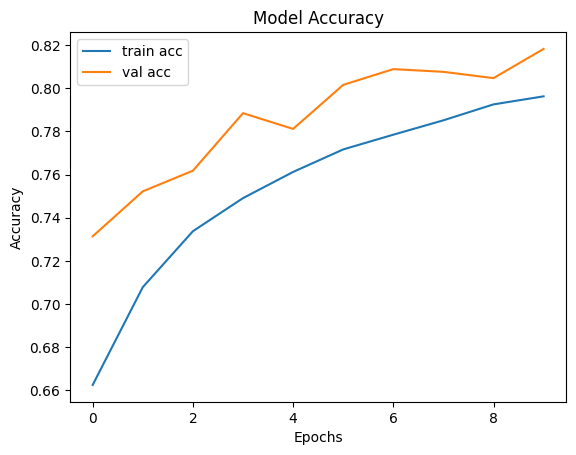

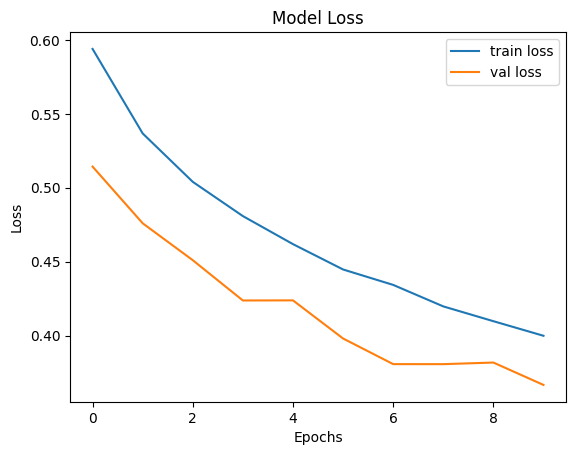

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen, epochs=5)


Epoch 1/5
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 597s 437ms/step - accuracy: 0.8070 - loss: 0.3869 - val_accuracy: 0.8470 - val_loss: 0.3125
Epoch 2/5
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 583s 432ms/step - accuracy: 0.8340 - loss: 0.3429 - val_accuracy: 0.8595 - val_loss: 0.2909
Epoch 3/5
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 582s 431ms/step - accuracy: 0.8537 - loss: 0.3102 - val_accuracy: 0.8424 - val_loss: 0.3152
Epoch 4/5
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 583s 431ms/step - accuracy: 0.8648 - loss: 0.2896 - val_accuracy: 0.8824 - val_loss: 0.2535
Epoch 5/5
1351/1351 ━━━━━━━━━━━━━━━━━━━━ 584s 432ms/step - accuracy: 0.8740 - loss: 0.2744 - val_accuracy: 0.8803 - val_loss: 0.2528


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save model to your Drive
model.save('/content/drive/MyDrive/vgg_model.h5')

print("Model saved to Google Drive: MyDrive/vgg_model.h5")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'model' is not defined

In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# === Paths ===
model_path = "/content/vgg_model.h5"   # Change if needed
csv_path = "/content/image_labels_limited.csv"
image_root = "/content/selected_img/selected_img"   # Adjust to your structure

# === Load dataset ===
df = pd.read_csv(csv_path)
print(df.head())
print("Unique labels:", df['Label'].unique())

# === Split train/val/test (example: 80/10/10, patient-wise) ===
from sklearn.model_selection import train_test_split

# keep only yes/no, drop others if any
df = df[df['Label'].isin(['yes', 'no'])]

patients = df['Case ID'].unique()
train_pat, test_pat = train_test_split(patients, test_size=0.1, random_state=42)
test_df = df[df['Case ID'].isin(test_pat)]
print("Test size:", len(test_df))


                                           ImageFile  Case ID Label
0  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
1  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
2  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
3  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
4  AMC-005/07-21-1994-NA-ThoraxCHESTNONCONTRAST A...  AMC-005   yes
Unique labels: ['yes' 'no']
Test size: 5500


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_root,
    x_col="ImageFile",
    y_col="Label",
    target_size=(224, 224),     # for VGG
    batch_size=32,
    shuffle=False
)


Found 5500 validated image filenames belonging to 2 classes.


In [ ]:
# Load the trained model
model = load_model(model_path)

# Predict (CPU ok, just slower)
pred_probs = model.predict(test_gen, verbose=1)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the true and predicted labels
y_true = df["Label"]
y_pred = df["pred_label"]



In [ ]:
# Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, pos_label='yes')  # 'yes' = positive class
rec = recall_score(y_true, y_pred, pos_label='yes')
f1 = f1_score(y_true, y_pred, pos_label='yes')

print("📈 Model Performance Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")


📈 Model Performance Metrics:
Accuracy : 0.8478
Precision: 0.7075
Recall   : 0.9915
F1 Score : 0.8257


In [ ]:
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred))



📋 Classification Report:
              precision    recall  f1-score   support

          no       0.99      0.77      0.86      3500
         yes       0.71      0.99      0.83      2000

    accuracy                           0.85      5500
   macro avg       0.85      0.88      0.85      5500
weighted avg       0.89      0.85      0.85      5500



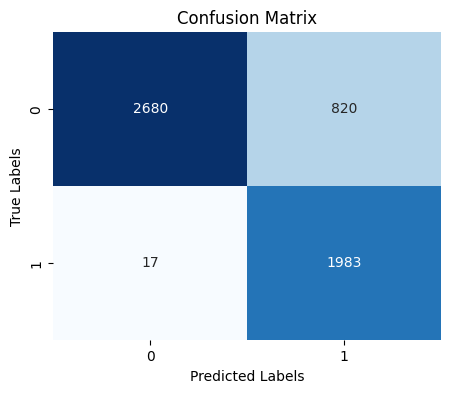

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


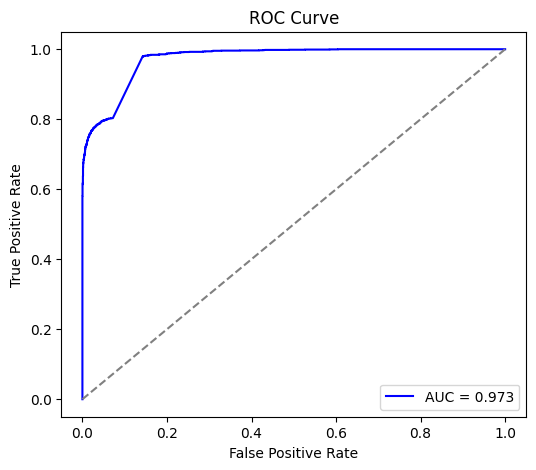

🔹 AUC Score: 0.9733


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Convert true labels to binary (yes=1, no=0)
y_true_bin = (y_true == "yes").astype(int)
y_prob = df["pred_prob"]

fpr, tpr, _ = roc_curve(y_true_bin, y_prob)
auc = roc_auc_score(y_true_bin, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print(f"🔹 AUC Score: {auc:.4f}")
